<h1 align="center">Segmentación de Clientes para DesignReels</h1>

En el competitivo mundo del comercio electrónico, entender a fondo a nuestros clientes es fundamental para ofrecer experiencias personalizadas y maximizar la satisfacción y lealtad del cliente. Este análisis de segmentación de clientes tiene como objetivo explorar y comprender las distintas características y comportamientos de los clientes que interactúan con nuestra tienda en línea, especializada en productos creativos.

Utilizando técnicas avanzadas de análisis de datos, como clustering y segmentación, este estudio buscará identificar grupos homogéneos de clientes. Estos segmentos nos permitirán personalizar estrategias de marketing más efectivas, optimizar la selección de productos y mejorar la experiencia general de compra. Al comprender las necesidades y preferencias únicas de cada segmento, aspiramos a fortalecer la conexión emocional con la marca y aumentar la retención de clientes a largo plazo.

A lo largo de este análisis, exploraremos cómo diferentes segmentos de clientes interactúan con nuestros productos, qué atributos compartidos tienen y cómo podemos adaptar nuestras iniciativas de negocio para satisfacer mejor sus expectativas. Este enfoque estratégico no solo impulsará el crecimiento y la rentabilidad de DesignReels, sino que también nos permitirá destacar en un mercado saturado al ofrecer soluciones que verdaderamente resuenen con nuestros clientes.

Juntos, avanzaremos hacia una comprensión más profunda de nuestros clientes y hacia la creación de experiencias de compra personalizadas y significativas que fortalezcan la posición de DesignReels como líder en su categoría de productos creativos.


# Diccionario de datos 

El conjunto de datos contiene información detallada sobre las transacciones de ventas de la tienda 

Descripción de las Columnas

- invoice_no: Número de factura generado para cada transacción.
- stock_code: Código único que identifica cada producto vendido.
- description: Descripción del producto vendido.
- quantity: Cantidad de unidades vendidas de cada producto en la factura.
- invoice_date: Fecha y hora en que se emitió la factura.
- unit_price: Precio unitario del producto en la factura.
- customer_id: Identificación única del cliente que realizó la compra.
- region: Región o ubicación del cliente.
- total: Total de la venta, calculado como la cantidad vendida multiplicada por el precio unitario.

In [89]:
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [90]:
df = pd.read_csv(r'datasets\Online_Retail.csv', encoding='iso-8859-1')

In [91]:
df.sample(10, random_state=7853)

,INVOICE_NO,STOCK_CODE,DESCRIPTION,QUANTITY,INVOICE_DATE,UNIT_PRICE,CUSTOMER_ID,REGION
94166,544335,22624,IVORY KITCHEN SCALES,3,17/02/2020 19:21,8.50,14702.0,United Kingdom
305697,563709,23298,SPOTTY BUNTING,1,18/08/2020 15:17,4.95,15472.0,United Kingdom
522802,580469,22343,PARTY PIZZA DISH RED RETROSPOT,3,04/12/2020 12:32,0.19,14583.0,United Kingdom
60563,541422,22214,CANDLE PLATE LACE WHITE,3,17/01/2020 17:48,1.63,NaN,United Kingdom
112696,545897,84872A,TEATIME FUNKY FLOWER BACKPACK FOR 2,1,07/03/2020 17:22,10.79,NaN,United Kingdom
318556,564837,22035,VINTAGE CARAVAN GREETING CARD,1,30/08/2020 12:40,0.83,NaN,United Kingdom
400292,571305,22900,SET 2 TEA TOWELS I LOVE LONDON,3,17/10/2020 09:55,4.13,NaN,United Kingdom
266032,560239,10133,COLOURING PENCILS BROWN TUBE,20,17/07/2020 11:50,0.42,13507.0,United Kingdom
160065,550447,21623,VINTAGE UNION JACK MEMOBOARD,1,18/04/2020 12:36,9.95,16033.0,United Kingdom
196259,553833,23082,SET 6 PAPER TABLE LANTERN HEARTS,2,19/05/2020 11:41,3.75,17346.0,United Kingdom


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   INVOICE_NO    541909 non-null  object 
 1   STOCK_CODE    541909 non-null  object 
 2   DESCRIPTION   540455 non-null  object 
 3   QUANTITY      541909 non-null  int64  
 4   INVOICE_DATE  541909 non-null  object 
 5   UNIT_PRICE    541909 non-null  float64
 6   CUSTOMER_ID   406829 non-null  float64
 7   REGION        541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [93]:
#cambio del nombre de las columnas a minusculas
new_col_name = []

for old_name in df.columns:
    name_stripped = old_name.strip()
    # Luego, pon todas las letras en minúsculas
    name_lowered = name_stripped.lower()
    # Por último, reemplaza los espacios entre palabras por guiones bajos
    name_no_spaces = name_lowered.replace(' ', '_')
    # Agrega el nuevo nombre a la lista de nuevos nombres de columna
    new_col_name.append(name_no_spaces)

df.columns = new_col_name


In [94]:
#cambio de tipo de la columna invoce_date a datetime
df['invoice_date']=pd.to_datetime(df['invoice_date'], format="%d/%m/%Y %H:%M")

#se llenan los nan de la columna customer_id con 0
df['customer_id'] = df['customer_id'].fillna(0)

#cambio del tipo de la columna customer_id a entero
df['customer_id'] = df['customer_id'].astype(int)

In [95]:
df.sample(10, random_state=7853)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
94166,544335,22624,IVORY KITCHEN SCALES,3,2020-02-17 19:21:00,8.50,14702,United Kingdom
305697,563709,23298,SPOTTY BUNTING,1,2020-08-18 15:17:00,4.95,15472,United Kingdom
522802,580469,22343,PARTY PIZZA DISH RED RETROSPOT,3,2020-12-04 12:32:00,0.19,14583,United Kingdom
60563,541422,22214,CANDLE PLATE LACE WHITE,3,2020-01-17 17:48:00,1.63,0,United Kingdom
112696,545897,84872A,TEATIME FUNKY FLOWER BACKPACK FOR 2,1,2020-03-07 17:22:00,10.79,0,United Kingdom
318556,564837,22035,VINTAGE CARAVAN GREETING CARD,1,2020-08-30 12:40:00,0.83,0,United Kingdom
400292,571305,22900,SET 2 TEA TOWELS I LOVE LONDON,3,2020-10-17 09:55:00,4.13,0,United Kingdom
266032,560239,10133,COLOURING PENCILS BROWN TUBE,20,2020-07-17 11:50:00,0.42,13507,United Kingdom
160065,550447,21623,VINTAGE UNION JACK MEMOBOARD,1,2020-04-18 12:36:00,9.95,16033,United Kingdom
196259,553833,23082,SET 6 PAPER TABLE LANTERN HEARTS,2,2020-05-19 11:41:00,3.75,17346,United Kingdom


In [96]:
df['region'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [97]:
#se remplaza el nombre de los paises agregaqdos como EIRE y RSA para unificar todos los nombres en ingles y mayusculas y minusculas 
df['region']= df['region'].replace('EIRE', 'Ireland')

df['region']= df['region'].replace('RSA', 'Sudafrica')

In [98]:
#verificacion de los valores menores a cero en la columan quantity. Aun falta determinar que tratamiento se le daran a estos datos 
df[df['quantity'] < 0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
141,C536379,D,Discount,-1,2019-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2019-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2019-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2019-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2019-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2020-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2020-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2020-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2020-12-09 11:58:00,1.25,17315,United Kingdom


In [99]:
#verificacion de los valores menores a cero en la columan unit_price. Aun falta determinar que tratamiento se le daran a estos datos 
df[df['unit_price'] < 0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
299983,A563186,B,Adjust bad debt,1,2020-08-12 14:51:00,-11062.06,0,United Kingdom
299984,A563187,B,Adjust bad debt,1,2020-08-12 14:52:00,-11062.06,0,United Kingdom


In [100]:
#se convierten las descripciones a minuscula para unificar el formato 
df['description'] = df['description'].str.lower()

In [101]:
#verificar que no existe ningun valor 0 en la columna quantity; sin embargo tener en cuenta que si existen aun menores a 0 
df[df['quantity'] == 0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region


In [102]:
#se decide eliminar del dataframe los datos que en unit_price y en customer_id sean iguales a 0, dado que consideramos no aportan ningun informacion util para futuros analisis
ceros = df.query(('unit_price > 0 & customer_id >= 0'))
display(ceros)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
0,536365,85123A,white hanging heart t-light holder,6,2019-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,white metal lantern,6,2019-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2019-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,2019-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,red woolly hottie white heart.,6,2019-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,pack of 20 spaceboy napkins,12,2020-12-09 12:50:00,0.85,12680,France
541905,581587,22899,children's apron dolly girl,6,2020-12-09 12:50:00,2.10,12680,France
541906,581587,23254,childrens cutlery dolly girl,4,2020-12-09 12:50:00,4.15,12680,France
541907,581587,23255,childrens cutlery circus parade,4,2020-12-09 12:50:00,4.15,12680,France


In [103]:
#verificacion relacionado con los datos eliminados 
ceros['description'].unique()

array(['white hanging heart t-light holder', 'white metal lantern',
       'cream cupid hearts coat hanger', ..., 'letter "u" bling key ring',
       'cream hanging heart t-light holder', 'paper craft  little birdie'],
      dtype=object)

In [104]:
#verificacion relacionado con los datos eliminados 
ceros['invoice_date'].dt.year.unique()


array([2019, 2020])

In [105]:
#verificacion relacionado con los datos eliminados 
ceros['invoice_date'].dt.month.unique()

array([12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [106]:
#se filta el data frame despues de las verificaciones anteriores para conservar unicamente los datos que sean diferentes a 0 

df = df.query('unit_price > 0.0')

df = df.query('customer_id > 0')

df = df.query('quantity > 0')

In [107]:
#creacion de una nueva columana que calcula el total vendido por factura 
df['total'] = df['quantity'] * df['unit_price']

In [108]:
#Se observan los valores maximos de la columna unit price y nos damos cuenta que hay facturas que no son productos como tal, cuyos monton son muy altos dado que el valor por unidad es elevado tambien
#al parecer estas facturas corresponden a gastos de envio y/0 gastos varios que podrian afectar nuestra analisis de clientes, dado que nos interesa unicamente sus compras se eliminan del dataset
df[df['unit_price']>= 450]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total
117054,546328,M,manual,1,2020-03-11 10:19:00,1687.17,14911,Ireland,1687.17
117055,546329,M,manual,1,2020-03-11 10:22:00,1687.17,14911,Ireland,1687.17
144826,548813,M,manual,1,2020-04-04 13:03:00,2382.92,12744,Singapore,2382.92
144828,548813,M,manual,1,2020-04-04 13:03:00,1252.95,12744,Singapore,1252.95
144829,548820,M,manual,1,2020-04-04 13:04:00,2053.07,12744,Singapore,2053.07
145831,548913,M,manual,1,2020-04-05 09:45:00,1136.30,12669,France,1136.30
150615,549468,M,manual,1,2020-04-08 14:27:00,1867.86,17940,United Kingdom,1867.86
173382,551697,POST,postage,1,2020-05-03 13:46:00,8142.75,16029,United Kingdom,8142.75
187584,552980,POST,postage,1,2020-05-12 14:52:00,523.00,12590,Germany,523.00
188277,553018,M,manual,1,2020-05-12 19:02:00,557.72,12757,Portugal,557.72


In [109]:
df = df.query("stock_code != 'M'")
df = df.query("stock_code != 'DOT'")
df = df.query("stock_code != 'POST'")

In [110]:
df[df['unit_price']>= 450]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total
222680,556444,22502,picnic basket wicker 60 pieces,60,2020-06-10 15:28:00,649.5,15098,United Kingdom,38970.0
222682,556446,22502,picnic basket wicker 60 pieces,1,2020-06-10 15:33:00,649.5,15098,United Kingdom,649.5


In [111]:
#se verificaron los posibles datos duplicados en todas las columanas posibles y concluimos que los duplicados existentes son coherentes. No se elimina ninguno
df['stock_code'].duplicated().sum()

392823

In [112]:
df.describe()

,quantity,invoice_date,unit_price,customer_id,total
count,396485.000000,396485,396485.000000,396485.000000,396485.000000
mean,13.008066,2020-07-10 20:02:19.138226944,2.884385,15301.436912,22.114122
min,1.000000,2019-12-01 08:26:00,0.001000,12346.000000,0.001000
25%,2.000000,2020-04-07 11:16:00,1.250000,13975.000000,4.680000
50%,6.000000,2020-07-31 14:39:00,1.950000,15159.000000,11.800000
75%,12.000000,2020-10-20 14:40:00,3.750000,16801.000000,19.800000
max,80995.000000,2020-12-09 12:50:00,649.500000,18287.000000,168469.600000
std,179.607863,NaN,4.354867,1709.758505,308.841950


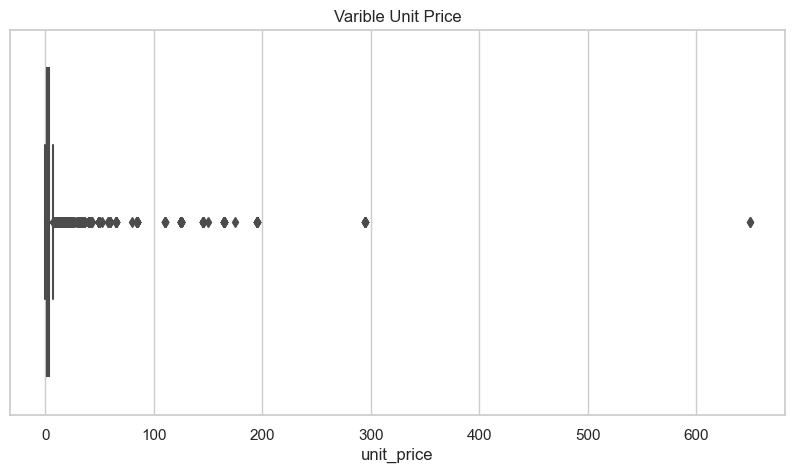

In [113]:
# Graficar un boxplot para identificar valores atípicos
plt.figure(figsize=(10,5))
sns.boxplot(x=df['unit_price'])
plt.title('Varible Unit Price')
plt.show()

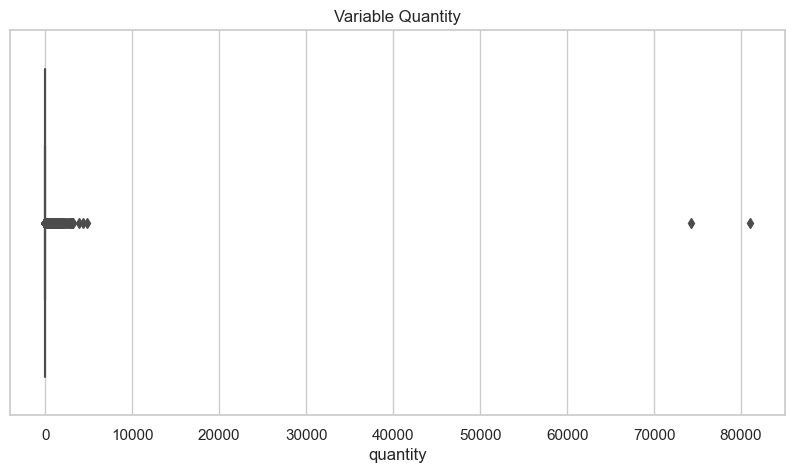

In [114]:
# Graficar un boxplot para identificar valores atípicos
plt.figure(figsize=(10,5))
sns.boxplot(x=df['quantity'])
plt.title('Variable Quantity')
plt.show()

In [115]:

# Modelo RFM 

df['invoice_date'] = pd.to_datetime(df['invoice_date'])
current_date = df['invoice_date'].max()

# Calcula Recencia, Frecuencia y Valor Monetario
rfm_df = df.groupby('customer_id').agg({
    'invoice_date': lambda x: (current_date - x.max()).days,
    'total': ['sum', 'count']
})

rfm_df.columns = ['Recency', 'Monetary', 'Frequency']
rfm_df.reset_index(inplace=True)

# Asigna puntuaciones RFM
rfm_df['R_rank'] = pd.qcut(rfm_df['Recency'], 5, labels=False, duplicates='drop') + 1
rfm_df['F_rank'] = pd.qcut(rfm_df['Frequency'], 5, labels=False, duplicates='drop') + 1
rfm_df['M_rank'] = pd.qcut(rfm_df['Monetary'], 5, labels=False, duplicates='drop') + 1

# Puedes combinar las puntuaciones en un código RFM para cada cliente
rfm_df['RFM_Score'] = rfm_df['R_rank'] + rfm_df['F_rank'] + rfm_df['M_rank']

# Muestra los resultados
display(rfm_df.head())

,customer_id,Recency,Monetary,Frequency,R_rank,F_rank,M_rank,RFM_Score
0,12346,326,77183.60,1,5,1,5,11
1,12347,1,4310.00,182,1,5,5,11
2,12348,74,1437.24,27,4,2,4,10
3,12349,18,1457.55,72,2,4,4,10
4,12350,310,294.40,16,5,2,2,9


In [116]:
# Obtener percentiles para la segmentación de clientes según RFM_Score
percentiles_rfm = np.percentile(rfm_df['RFM_Score'], [20, 40, 60, 80])

print('Percentiles del RFM Score:', percentiles_rfm)

Percentiles del RFM Score: [ 7.  8. 10. 11.]


In [117]:

def segment_customer(row, percentil):
    """
    Segmenta a los clientes en diferentes categorías basadas en su RMF_Score.
    """
    if row['RFM_Score'] > percentil[3]:
        return 'Alto valor'
    elif row['RFM_Score'] > percentil[2]:
        return 'Leal'
    elif row['RFM_Score'] > percentil[1]:
        return 'Potencial'
    elif row['RFM_Score'] > percentil[0]:
        return 'Activo'
    else:
        return 'Cliente Perdido' 

# Aplica la función de segmentación a cada fila del DataFrame
rfm_df['Segment'] = rfm_df.apply(segment_customer, axis=1, args=(percentiles_rfm, ))

# Muestra los resultados
display(rfm_df.head())

,customer_id,Recency,Monetary,Frequency,R_rank,F_rank,M_rank,RFM_Score,Segment
0,12346,326,77183.60,1,5,1,5,11,Leal
1,12347,1,4310.00,182,1,5,5,11,Leal
2,12348,74,1437.24,27,4,2,4,10,Potencial
3,12349,18,1457.55,72,2,4,4,10,Potencial
4,12350,310,294.40,16,5,2,2,9,Potencial


In [118]:
# Conteo de clientes por segmento
print(rfm_df['Segment'].value_counts())

Segment
Cliente Perdido    1276
Potencial          1260
Leal                688
Alto valor          573
Activo              538
Name: count, dtype: int64


In [119]:
# Calcular el - Customer Lifetime Value o CLTV

# Calcular el Valor Promedio por Compra (APV)
rfm_df['APV'] = rfm_df['Monetary'] / rfm_df['Frequency']

In [120]:

# Definir el período de tiempo para el análisis de retención anual

df['yearly'] = df['invoice_date'].dt.to_period('Y')

# Identificar clientes únicos por año
customers_per_period = df.groupby('yearly')['customer_id'].nunique()

# Crear una lista dea años ordenados
periods = sorted(df['yearly'].unique())

# Calcular la retención de clientes
retention = []

for i in range(1, len(periods)):
    current_period = periods[i]
    previous_period = periods[i-1]
    
    # Clientes en el período actual y el anterior
    current_customers = set(df[df['yearly'] == current_period]['customer_id'])
    previous_customers = set(df[df['yearly'] == previous_period]['customer_id'])
    
    # Clientes retenidos
    retained_customers = current_customers.intersection(previous_customers)
    
    # Calcular la tasa de retención
    retention_rate = len(retained_customers) / len(previous_customers) if len(previous_customers) > 0 else 0
    retention.append(retention_rate)

# Mostrar las tasas de retención por período
for i in range(1, len(periods)):
    print(f"Tasa de retención de {periods[i-1]} a {periods[i]}: {retention[i-1]:.2%}")

Tasa de retención de 2019 a 2020: 86.33%


In [121]:
retention_rate = retention[0]
churn_rate = 1 - retention_rate

# Calcular el CLTV
rfm_df['CLTV'] = rfm_df['APV'] * (retention_rate / churn_rate)

print(rfm_df[['customer_id', 'Recency', 'Frequency', 'Monetary', 'CLTV']])

      customer_id  Recency  Frequency  Monetary           CLTV
0           12346      326          1  77183.60  487341.077686
1           12347        1        182   4310.00     149.525020
2           12348       74         27   1437.24     336.103875
3           12349       18         72   1457.55     127.820041
4           12350      310         16    294.40     116.178512
...           ...      ...        ...       ...            ...
4330        18280      277         10    180.60     114.031736
4331        18281      180          7     80.82      72.900213
4332        18282        7         12    178.05      93.684711
4333        18283        3        754   2088.93      17.492848
4334        18287       42         70   1837.28     165.723957

[4335 rows x 5 columns]


In [122]:
# Obtener percentiles para la segmentación de clientes según CLTV

percentiles = np.percentile(rfm_df['CLTV'], [20, 40, 60, 80])

print('Percentiles del CLTV:', percentiles)

Percentiles del CLTV: [ 60.51854331 101.70960628 122.25887876 177.1728255 ]


In [123]:
def segment_customer_by_cltv(row, p):
    """
    Segmenta a los clientes en diferentes categorías basadas en su CLTV.
    """
    if row['CLTV'] > p[3]:  # Mayor que el percentil 80
        return 'Alto valor'
    elif row['CLTV'] > p[2]:  # Entre el percentil 60 y 80
        return 'Leal'
    elif row['CLTV'] > p[1]:  # Entre el percentil 40 y 60
        return 'Potencial'
    elif row['CLTV'] > p[0]:  # Entre el percentil 20 y 40
        return 'Ocacional'
    else:  # Menor que el percentil 20
        return 'Cliente Perdido'

# Aplica la función de segmentación a cada fila del DataFrame
rfm_df['CLTV_Segment'] = rfm_df.apply(segment_customer_by_cltv, axis=1, args=(percentiles, ))

# Muestra los primeros registros para verificar
display(rfm_df.sample(10))


print(rfm_df['CLTV_Segment'].value_counts())


,customer_id,Recency,Monetary,Frequency,R_rank,F_rank,M_rank,RFM_Score,Segment,APV,CLTV,CLTV_Segment
2335,15526,32,148.44,4,2,1,1,4,Cliente Perdido,37.110000,234.314380,Alto valor
3509,17142,238,579.00,15,5,2,3,10,Potencial,38.600000,243.722314,Alto valor
2621,15916,15,1528.09,155,2,5,4,11,Leal,9.858645,62.247974,Ocacional
520,13028,22,661.32,45,2,3,3,8,Activo,14.696000,92.791273,Ocacional
266,12673,4,574.52,41,1,3,3,7,Cliente Perdido,14.012683,88.476775,Ocacional
552,13072,266,177.15,7,5,1,1,7,Cliente Perdido,25.307143,159.790555,Leal
4327,18276,43,335.86,14,3,1,2,6,Cliente Perdido,23.990000,151.474050,Leal
4231,18147,45,179.34,7,3,1,1,5,Cliente Perdido,25.620000,161.765950,Leal
264,12670,9,2744.05,87,1,4,5,10,Potencial,31.540805,199.150204,Alto valor
4222,18135,28,681.91,20,2,2,3,7,Cliente Perdido,34.095500,215.280678,Alto valor


CLTV_Segment
Alto valor         867
Leal               867
Potencial          867
Ocacional          867
Cliente Perdido    867
Name: count, dtype: int64


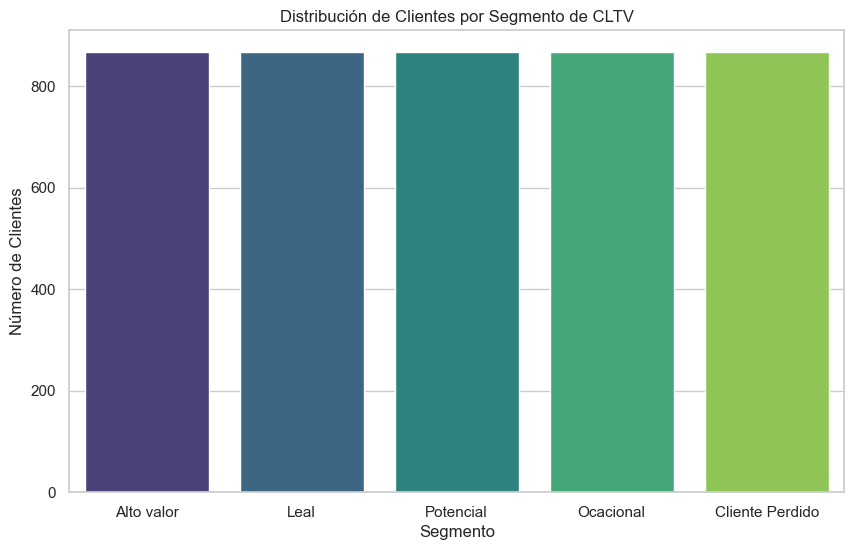

In [124]:
# Contar el número de clientes en cada segmento de CLTV
cltv_segment_counts = rfm_df['CLTV_Segment'].value_counts()

# Crear una gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=cltv_segment_counts.index, y=cltv_segment_counts.values, palette='viridis')
plt.title('Distribución de Clientes por Segmento de CLTV')
plt.xlabel('Segmento')
plt.ylabel('Número de Clientes')
plt.show()


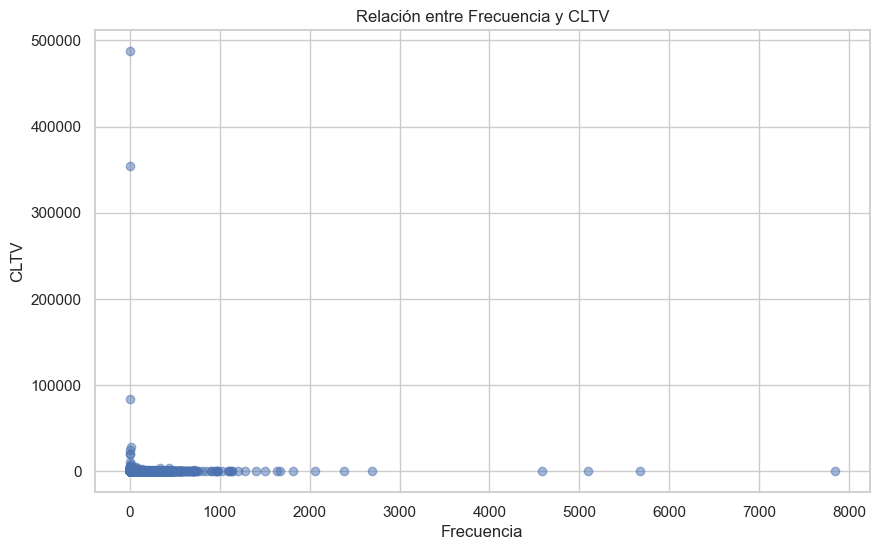

In [125]:
# Gráfico de dispersión para ver la relación entre CLTV y Frequency
plt.figure(figsize=(10, 6))
plt.scatter(rfm_df['Frequency'], rfm_df['CLTV'], alpha=0.5)
plt.title('Relación entre Frecuencia y CLTV')
plt.xlabel('Frecuencia')
plt.ylabel('CLTV')
plt.show()


In [126]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Dividir los datos en características y objetivos
X = rfm_df[['Recency', 'Frequency', 'Monetary', 'CLTV']]
y = rfm_df['CLTV_Segment']  

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo de árbol de decisión
model = DecisionTreeClassifier()

# Entrenar el modelo
model.fit(X_train, y_train)

# Predecir con el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")


Precisión del modelo: 1.00


In [127]:
# Predecir el tipo de cliente usando el modelo entrenado

# Nuevo cliente con estas características
new_customer = {
    'Recency': 1,
    'Frequency': 5,
    'Monetary': 100,
    'CLTV': 50
}

new_df = pd.DataFrame([new_customer])

predicted_segment = model.predict(new_df)
print(f"El nuevo cliente pertenece al segmento: {predicted_segment}")


El nuevo cliente pertenece al segmento: ['Cliente Perdido']


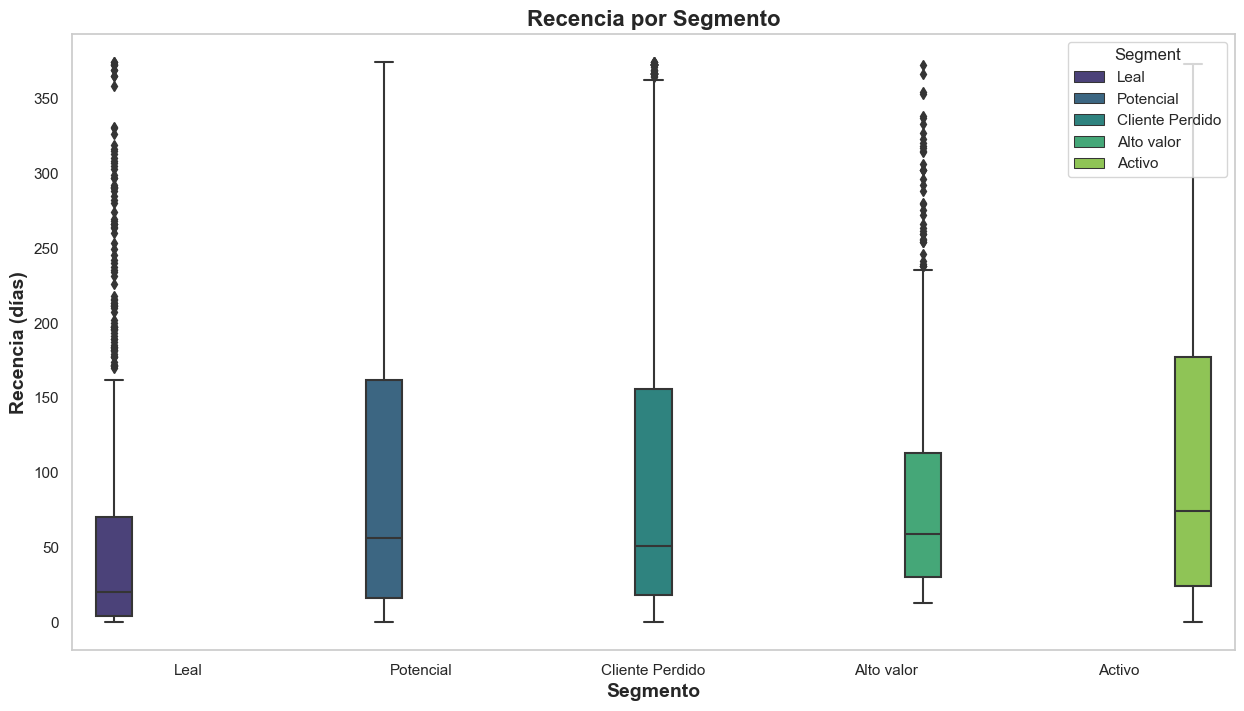

In [128]:
# Gráfico de Caja y Bigote para Recencia por Segmento
plt.figure(figsize=(15, 8))
sns.boxplot(data=rfm_df, x='Segment', y='Recency', palette='viridis', hue='Segment')
plt.title('Recencia por Segmento', fontsize=16, fontweight='bold')
plt.xlabel('Segmento', fontsize=14, fontweight='bold')
plt.ylabel('Recencia (días)', fontsize=14, fontweight='bold')
#plt.xticks(rotation=45)
plt.grid(False)
plt.show()

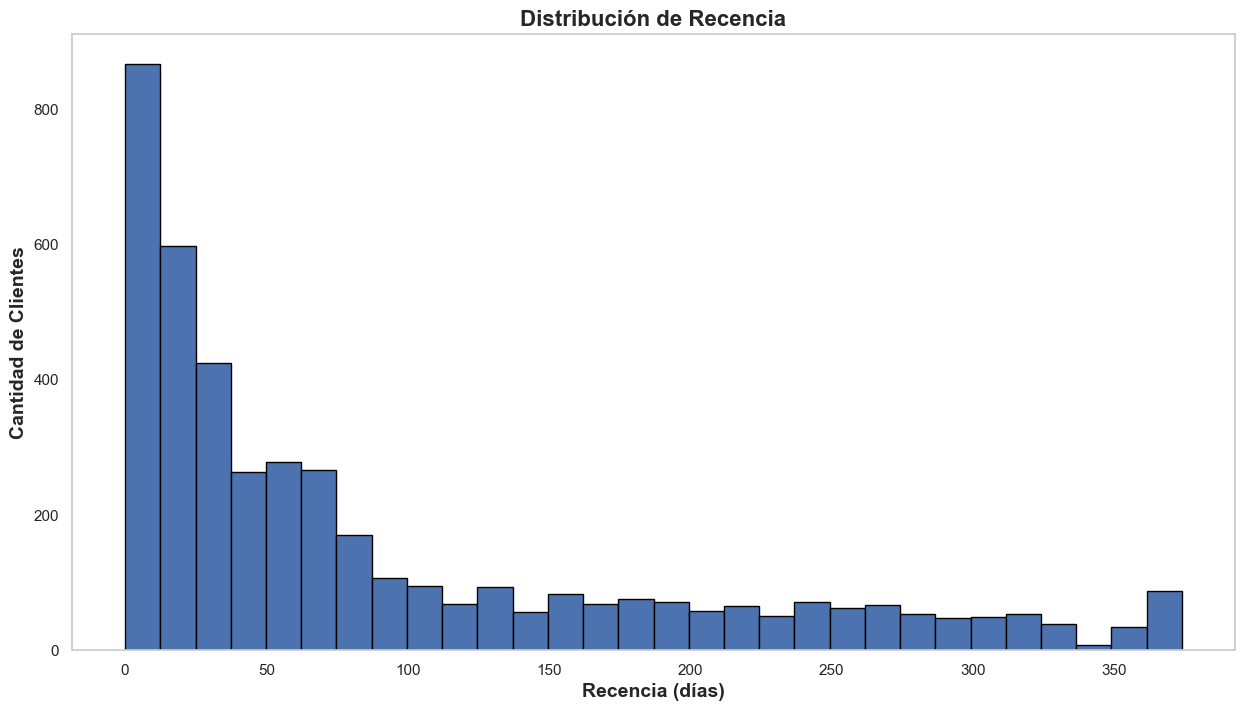

In [129]:
# Histogramas
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))
rfm_df['Recency'].hist(bins=30, edgecolor='black', grid=False)
plt.title('Distribución de Recencia', fontsize=16, fontweight='bold')
plt.xlabel('Recencia (días)', fontsize=14, fontweight='bold')
plt.ylabel('Cantidad de Clientes', fontsize=14, fontweight='bold')
plt.show()

Podemos concluir que la mayoria de los clientes esperan entre 3 años 

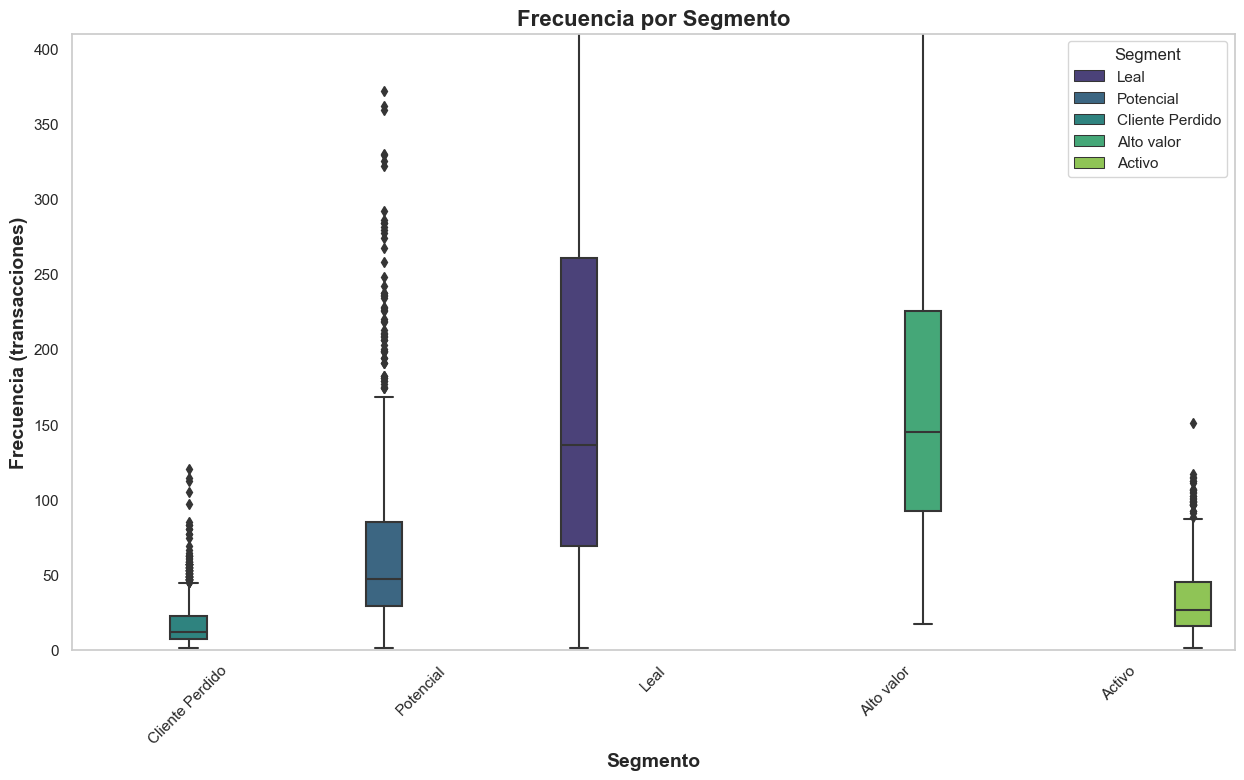

In [130]:
# Gráfico de Caja y Bigote para Frecuencia por Segmento
plt.figure(figsize=(15, 8))
sns.boxplot(data=rfm_df, x='Segment', y='Frequency', palette='viridis', order=rfm_df['Segment'].value_counts().index, hue='Segment' )#showfliers=False
plt.title('Frecuencia por Segmento',  fontsize=16, fontweight='bold')
plt.xlabel('Segmento',  fontsize=14, fontweight='bold')
plt.ylabel('Frecuencia (transacciones)',  fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.ylim(0, 410)
plt.grid(False)
plt.show()


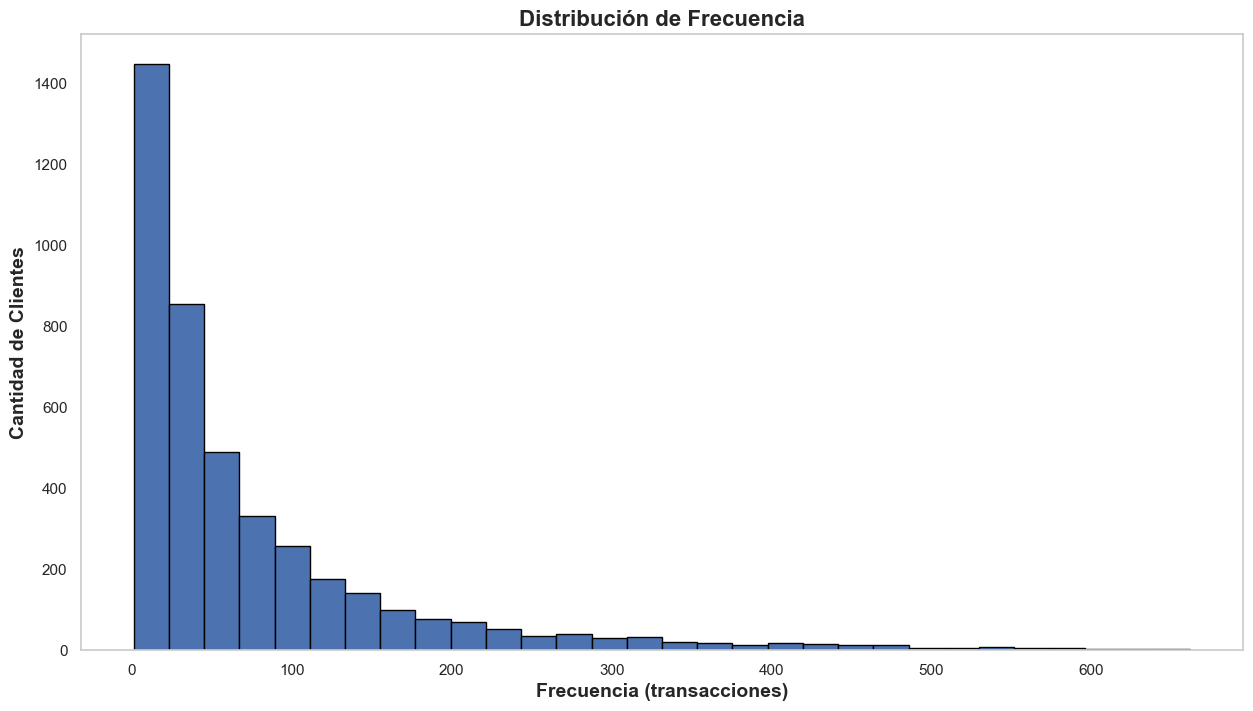

In [131]:
sns.set(style="whitegrid")
filtered_data_f = rfm_df[rfm_df['Frequency'] < rfm_df['Frequency'].quantile(0.99)]
plt.figure(figsize=(15, 8))
filtered_data_f['Frequency'].hist(bins=30, edgecolor='black', grid=False)
plt.title('Distribución de Frecuencia', fontsize=16, fontweight='bold')
plt.xlabel('Frecuencia (transacciones)', fontsize=14, fontweight='bold')
plt.ylabel('Cantidad de Clientes', fontsize=14, fontweight='bold')

plt.show()

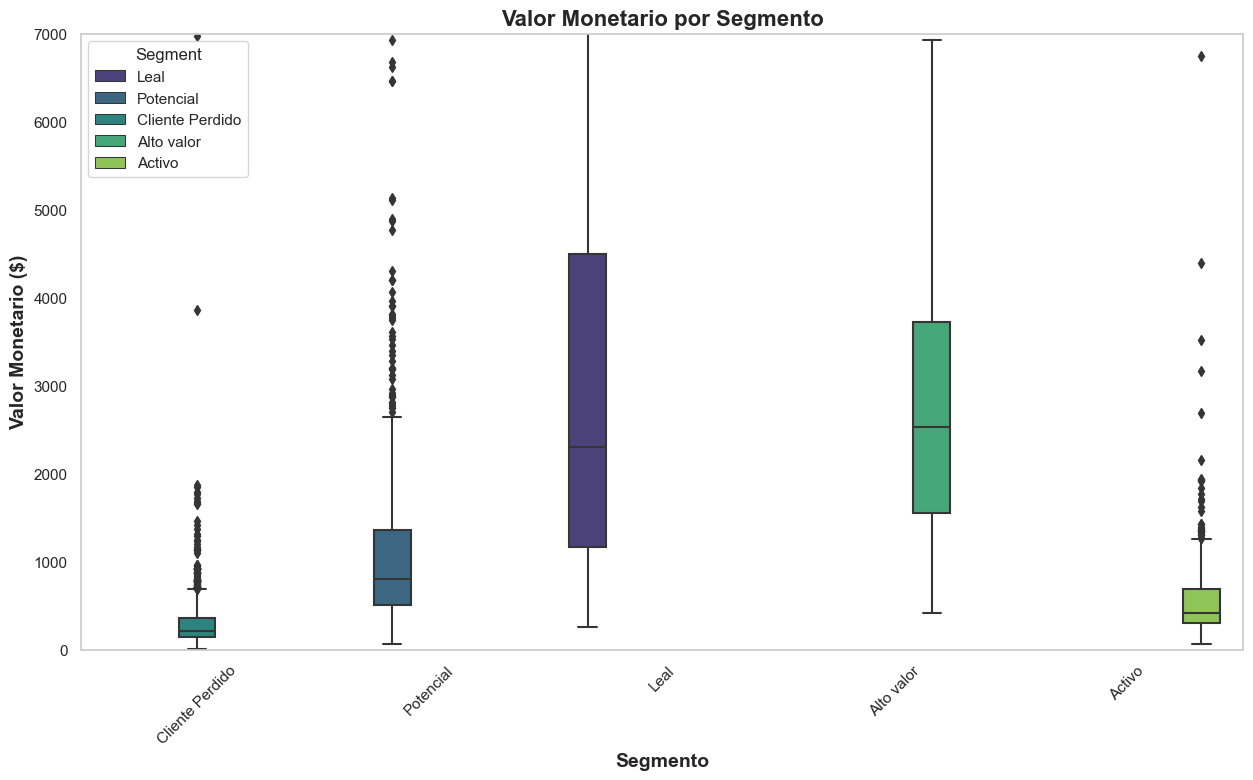

In [132]:
# Gráfico de Caja y Bigote para Valor Monetario por Segmento
plt.figure(figsize=(15, 8))
sns.boxplot(data=rfm_df, x='Segment', y='Monetary', palette='viridis', order=rfm_df['Segment'].value_counts().index, hue='Segment')
plt.title('Valor Monetario por Segmento', fontsize=16, fontweight='bold')
plt.xlabel('Segmento', fontsize=14, fontweight='bold')
plt.ylabel('Valor Monetario ($)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.ylim(0, 7000)

plt.grid(False)
plt.show()

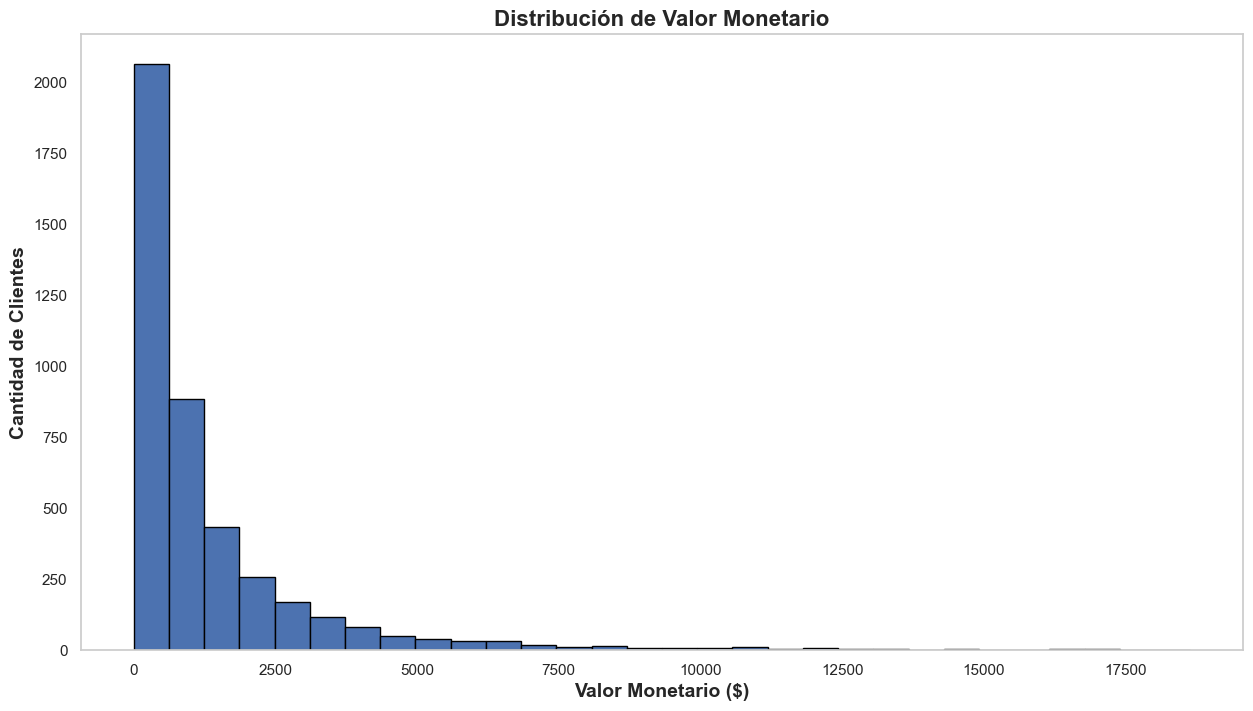

In [133]:
sns.set(style="whitegrid")
filtered_data_m = rfm_df[rfm_df['Monetary'] < rfm_df['Monetary'].quantile(0.99)]
plt.figure(figsize=(15, 8))
filtered_data_m['Monetary'].hist(bins=30, edgecolor='black', grid= False)
plt.title('Distribución de Valor Monetario', fontsize=16, fontweight='bold')
plt.xlabel('Valor Monetario ($)', fontsize=14, fontweight='bold')
plt.ylabel('Cantidad de Clientes', fontsize=14, fontweight='bold')
plt.ticklabel_format(style='plain', axis='x')

plt.show()


c:\Users\Det-Pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Det-Pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Det-Pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Det-Pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

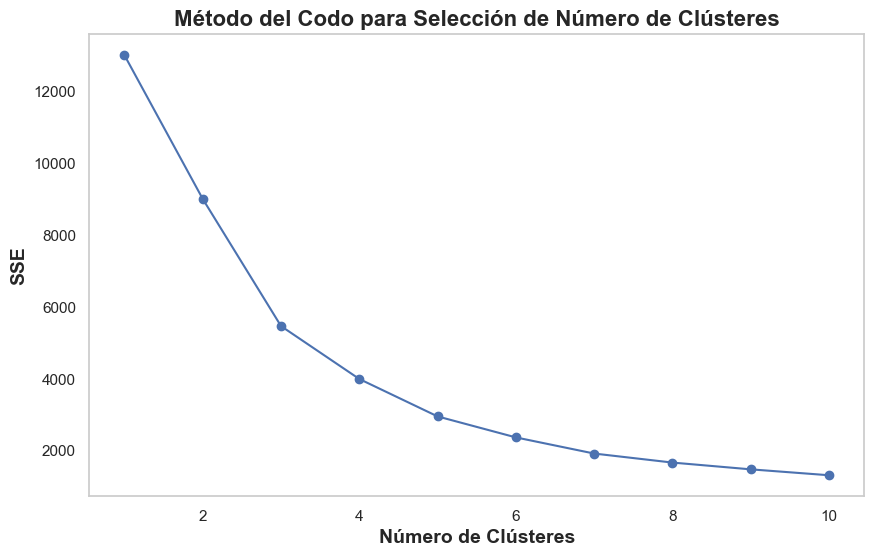

c:\Users\Det-Pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


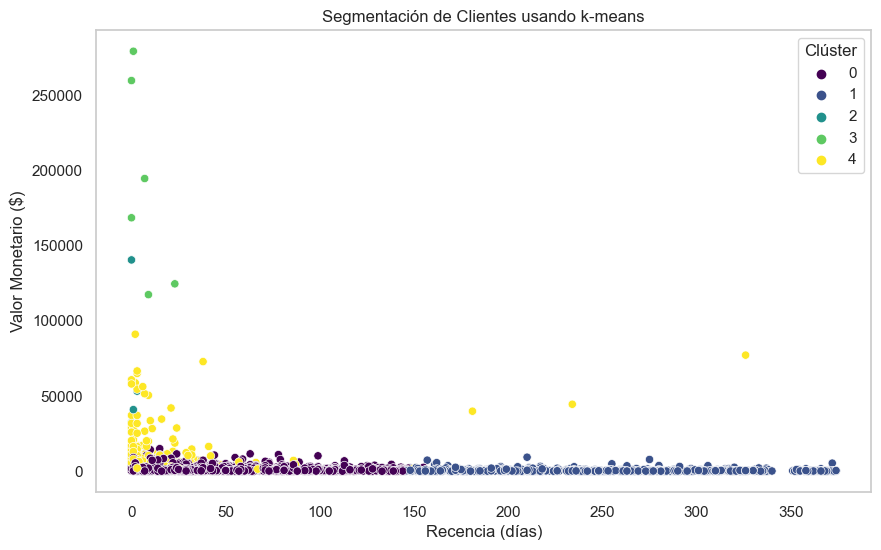

Cluster
0    3018
1    1060
4     247
3       6
2       4
Name: count, dtype: int64


Recency        Frequency          Monetary                
           mean median      mean  median      mean    median count
Cluster                                                           
0          43.2   32.0      72.8    50.0    1320.5     798.2  3018
1         248.7  243.5      27.9    18.0     488.4     308.4  1060
2           1.0    0.5    5796.5  5384.0   66748.5   47113.1     4
3           6.7    4.0     824.0   572.0  190627.1  181511.6     6
4          14.9    7.0     481.6   408.0   11555.8    6424.1   247

In [134]:
# Normalizar los datos
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Método del codo para encontrar el número óptimo de clústeres
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Método del Codo para Selección de Número de Clústeres', fontsize=16, fontweight='bold')
plt.xlabel('Número de Clústeres', fontsize=14, fontweight='bold')
plt.ylabel('SSE', fontsize=14, fontweight='bold')
plt.grid(False)
plt.show()

# Aplicar k-means con el número óptimo de clústeres (supongamos k=4)
kmeans = KMeans(n_clusters=5, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_normalized)

# Visualizar los clústeres
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Segmentación de Clientes usando k-means')
plt.xlabel('Recencia (días)')
plt.ylabel('Valor Monetario ($)')
plt.legend(title='Clúster')
plt.grid(False)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

# Distribución de clientes por clúster
print(rfm_df['Cluster'].value_counts())

# Estadísticas descriptivas por clúster
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median', 'count']
}).round(1)
display(cluster_summary)


c:\Users\Det-Pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster Summary Sorted by Monetary Value:
          Recency  Frequency  Monetary
Cluster                              
1          248.7       27.9     488.4
0           43.2       72.8    1320.5
4           14.9      481.6   11555.8
2            1.0     5796.5   66748.5
3            6.7      824.0  190627.1


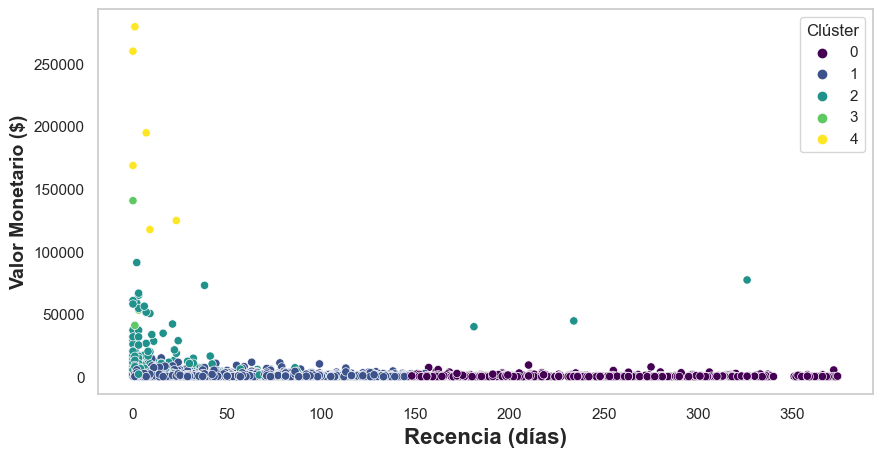

Cluster
1    3018
0    1060
2     247
4       6
3       4
Name: count, dtype: int64
Cluster Summary Ordered:
         Recency        Frequency          Monetary                
           mean median      mean  median      mean    median count
Cluster                                                           
0         248.7  243.5      27.9    18.0     488.4     308.4  1060
1          43.2   32.0      72.8    50.0    1320.5     798.2  3018
2          14.9    7.0     481.6   408.0   11555.8    6424.1   247
3           1.0    0.5    5796.5  5384.0   66748.5   47113.1     4
4           6.7    4.0     824.0   572.0  190627.1  181511.6     6


In [135]:
# Aplicar k-means con el número óptimo de clústeres k=4
kmeans = KMeans(n_clusters=5, random_state=42)

rfm_df['Cluster'] = kmeans.fit_predict(rfm_normalized)

# Calcular estadísticas descriptivas por clúster
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(1)

# Ordenar los clústeres por valor monetario promedio
cluster_summary = cluster_summary.sort_values(by='Monetary')
print("Cluster Summary Sorted by Monetary Value:\n", cluster_summary)

# Crear un diccionario para mapear los clústeres originales a los nuevos clústeres ordenados
cluster_mapping = {old_cluster: new_cluster for new_cluster, old_cluster in enumerate(cluster_summary.index)}

# Reasignar los números de clústeres en el DataFrame original
rfm_df['Cluster'] = rfm_df['Cluster'].map(cluster_mapping)

# Visualizar los clústeres ordenados
plt.figure(figsize=(10,5))
sns.scatterplot(data=rfm_df, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.xlabel('Recencia (días)', fontsize=16, fontweight='bold')
plt.ylabel('Valor Monetario ($)', fontsize=14, fontweight='bold')
plt.legend(title='Clúster')
plt.grid(False)
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

# Distribución de clientes por clúster ordenado
print(rfm_df['Cluster'].value_counts())

# Estadísticas descriptivas por clúster ordenado
cluster_summary_ordered = rfm_df.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median', 'count']
}).round(1)
print("Cluster Summary Ordered:\n", cluster_summary_ordered)

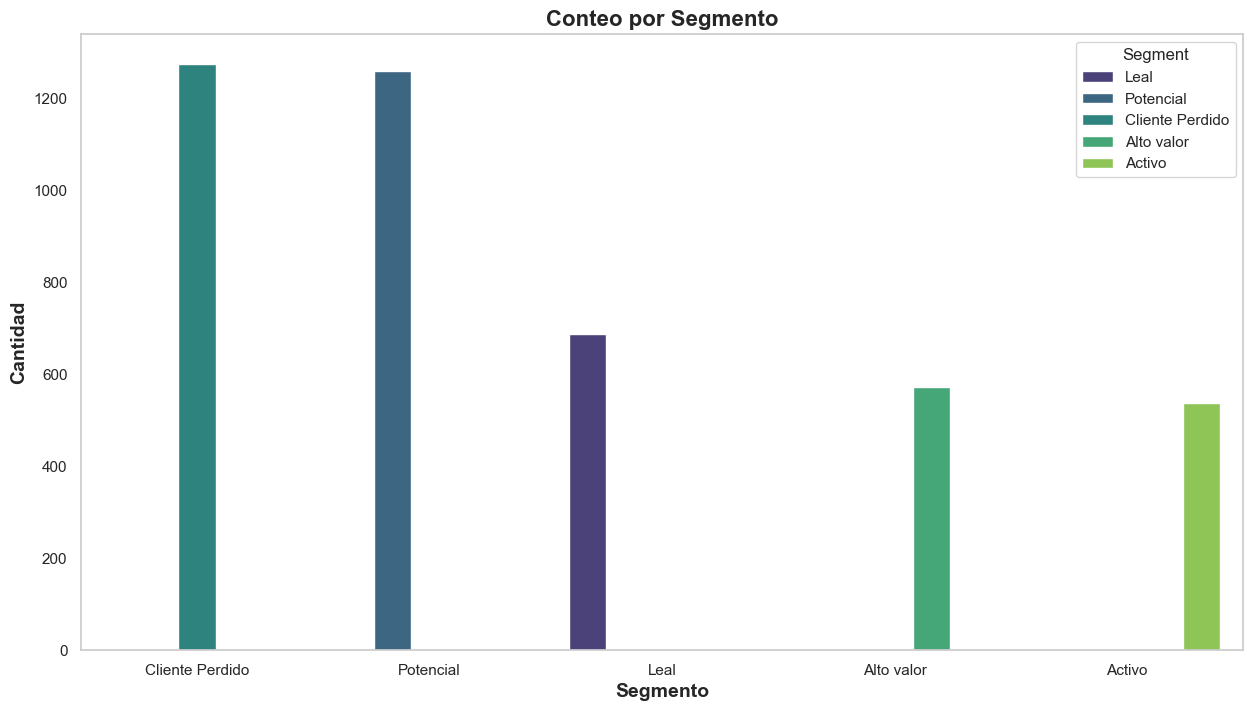

In [137]:
# Gráfico de Barras de la Distribución de Segmentos

sns.set(style="whitegrid")

plt.figure(figsize=(15,8))
sns.countplot(data=rfm_df, x='Segment', order=rfm_df['Segment'].value_counts().index, hue='Segment', palette='viridis')


plt.title('Conteo por Segmento', fontsize=16, fontweight='bold')
plt.xlabel('Segmento', fontsize=14, fontweight='bold')
plt.ylabel('Cantidad', fontsize=14, fontweight='bold')

plt.grid(False)
plt.show()

Se realizo una segmentacion de cliente con base en la frecuencia con la que compran en la tienda, el monto que suelen gastar en sus compras y el tiempo transcurrido desde su ultima combra. Se obtuvieron 5 segmentos que dividen a los clientes en:
- *Potencial*: Son clientes con actividad superior a la media, en los cuales podemos enformar algun programa especifico para incentivarlos a convertirlos en clientes leales o de alto valor.
- *Leal*: En este grupo encontraremos a los clientes aliosos para la empresa, ya que son propensos a realizar compras repetidas y recomendar nuestros productos o servicios a otros.
- *Activo*: Clientes que utilizan compran nuestros productos de manera regular, sin llegar a superar el promedio de compras o visitas. Este segmento representa la mayor oportunidad de crecimiento para la empresa. Se deben implementar estrategias para aumentar la satisfacción y la lealtad de estos clientes.
- *Alto valor*: Estos clientes generan la mayor parte de los ingresos para la empresa. Es importante enfocarse en este segmento para mantener su satisfacción y lealtad.
- *Cliente Churn*: Estos clientes ya no compran nuestros productos. Es de vital importancia enfocarse en este segmento y analizar las razones por las que estos clientes se han perdido y tomar medidas para evitar que otros clientes se pierdan en el futuro.

In [138]:
rfm_df.sample(10)

,customer_id,Recency,Monetary,Frequency,R_rank,F_rank,M_rank,RFM_Score,Segment,APV,CLTV,CLTV_Segment,Cluster
1203,13979,72,869.87,54,4,3,3,10,Potencial,16.108704,101.711154,Potencial,1
987,13680,0,3722.42,195,1,5,5,11,Leal,19.089333,120.530997,Potencial,1
2039,15129,49,3447.40,84,3,4,5,12,Alto valor,41.040476,259.131602,Alto valor,1
2227,15381,213,596.85,8,5,1,3,9,Potencial,74.606250,471.067562,Alto valor,0
944,13615,319,417.69,23,5,2,2,9,Potencial,18.160435,114.665886,Potencial,0
869,13508,243,110.97,12,5,1,1,7,Cliente Perdido,9.247500,58.389174,Cliente Perdido,0
2545,15808,306,3734.97,208,5,5,5,15,Alto valor,17.956587,113.378778,Potencial,0
766,13363,17,992.50,60,2,4,4,10,Potencial,16.541667,104.444904,Potencial,1
4251,18174,6,104.00,1,1,1,1,3,Cliente Perdido,104.000000,656.661157,Alto valor,1
2379,15584,23,725.11,123,2,5,3,10,Potencial,5.895203,37.222606,Cliente Perdido,1


In [139]:
def churn(row):
    if row == 'Cliente Perdido':
        return 1 # cliente perdido o que probablemente abandone pronto
    else:
        return 0 #menos probabilidad de abandono 



rfm_df['Churn'] = rfm_df['Segment'].apply(churn)